# Глубинное обучение для текстовых данных, ФКН ВШЭ
## Домашнее задание 5: Retrieval‑Augmented Generation (RAG)
### Оценивание и штрафы

Максимально допустимая оценка за работу — __12 баллов__.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Весь код должен быть написан самостоятельно. Чужим кодом для пользоваться запрещается даже с указанием ссылки на источник. В разумных рамках, конечно. Взять пару очевидных строчек кода для реализации какого-то небольшого функционала можно.

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

__Мягкий дедлайн 04.12.25 23:59__ \
__Жесткий дедлайн 07.12.25 23:59__

### О задании

В этом домашнем задании вам предлагается реализовать ассистента для кулинарных советов с помощью RAG, который помимо всего прочего может ходить в итернет за дополнительной информацией. Всю логику системы нужно будет написать самостоятельно без специализорованных библиотек. Мы разделили ее на несколько логических компонент, каждой из которых будет отведено отдельное задание:
1. Векторная база данных с быстрым семантическим поиском
2. Разбиение текстов на куски.
3. Ранжирование документов по релевантности
4. Формирование контекста для модели и генерация ответа

### О данных

В качестве базы данных мы будем использовать пользовательские рецепты с сайта "Поваренок.Ру". Они получены с помощью веб-парсинга сайта, поэтому местами тексты недостаточно чистые. Всего в датасете содержится 84130 рецептов.

In [ ]:
import pickle
import torch

import matplotlib.pyplot as plt
import numpy as np

### Загрузка датасета и модели

Таблица с рецептами хранится в файле `povarenok.csv`. Каждая запись содержит название рецепта, список ингредиентов и сам рецепт. Несмотря на то, что всего датасете хранится 84130 записей, в рамках этого задания мы будем работать с первыми 10-ю тысячами для того, чтобы все работало быстрее. При желании вы можете взять больше.

In [ ]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files=['/kaggle/input/povarenok/povarenok.csv'], split='train')
dataset = dataset.select(range(10000))
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['name', 'ingredients', 'text'],
    num_rows: 10000
})

In [ ]:
len(dataset)

10000

Посмотрим на распределение длин текстов. Нам важно знать с чем мы имеем дело, ведь RAG подразумевает, что мы будем подавать тексты на вход модели.

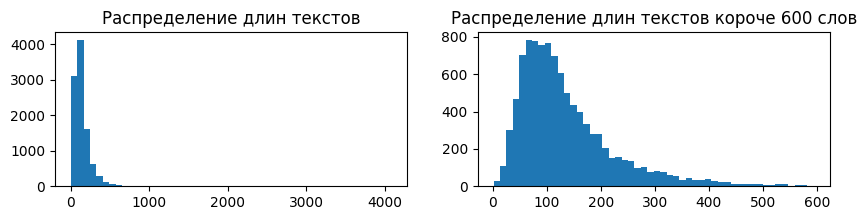

In [ ]:
lens = np.array([len(dataset[i]['text'].split()) for i in range(len(dataset))])

plt.figure(figsize=(10, 2))
plt.subplot(1, 2, 1)
plt.hist(lens, bins=50)
plt.title('Распределение длин текстов')

plt.subplot(1, 2, 2)
plt.hist(lens[lens < 600], bins=50)
plt.title('Распределение длин текстов короче 600 слов')

plt.show()

Видим, что тексты часто довольно длинные. Поэтому смухлевать не получится и перед векторизацией нужно будет разбивать каждый текст на небольшие куски, чтобы не перегружать контекст модели и чтобы потерять важную информацию при векторизацци текстов на этапе складывания их в векторную базу данных.

Приступим к реализации RAG.

## Retrieval‑Augmented Generation

В качестве основы для ассистента возьмите модель [`Qwen/Qwen2-1.5B-Instruct`](https://huggingface.co/Qwen/Qwen2-1.5B-Instruct) из huggingface. Важно, что это `Instruct` модель, то есть она предлазначена для общения в формате диалога.

__Задание 0 (0 баллов).__ Проверьте, как модель отвечает на кулинарные вопросы без RAG. Это необходимо сделать, чтобы понять, нужен ли вообще RAG для данной задачи.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
device = "cuda" # the device to load the model onto

model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2-1.5B-Instruct",
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-1.5B-Instruct")

prompt = "Как приготовить клубничный молочный коктейль?"
messages = [
    {"role": "system", "content": "Ты повар и даешь консультации по приготовлению блюд, помогаешь с подбором рецептов."},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(device)

generated_ids = model.generate(
    model_inputs.input_ids,
    max_new_tokens=512
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]


In [ ]:
response

'Клубничный молочный коктейль - это очень легкий и вкусный напиток, который можно сделать на основе свежих клубниковых ягод и молока.\n\n**Ингредиенты:**\n- 1 стакан свежих клубники\n- 2 чашки молока\n- 1/4 чайной ложки корицы (по желанию)\n- Лимонная или апельсиновая пудра для украшения\n\n**Приготовление:**\n\n1. **Свежие клубники:** Нарежьте клубнику на маленькие кусочки. Это поможет вам быстрее разогреть ее в микроволновке.\n\n2. **Время приготовления:** Вставьте все ингредиенты в морозильную камеру на полчаса до состояния мягкого сливочного сыра. \n\n3. **Микроволновая печь:** Если вы не используете морозильную камеру, добавьте все ингредиенты в микроволновую печь и перемешайте их минут 30-60. Поставьте на 15 секунд на высокое ускорение и оставьте остывать до тепла.\n\n4. **Украска:** Перемешайте клубнику с молоком, затем добавьте корицу. Добавьте лимонную или апельсиновую пудру для дополнительного аромата. Украсьте коктейлем сверху листьями мяты или шалфея.\n\nЭто ваш клубничный 

Выглядит, мягко говоря, не очень. Логической связи нет вообще.

### Locality Sensitive Hashing (LSH)

В RAG для каждого запроса необходимо искать релевантные документы по векторной базе данных. Так как документов очень много, подсчет релевантности для каждого из них будет занимать очень много времени. Поэтому нам важно, чтобы поиск был быстрым. Для достижения этого мы даже готовы немного пожертвовать точностью.

В этой секции вам предстоит реализовать [Locality Sensitive Hashing](https://ru.wikipedia.org/wiki/Locality-sensitive_hashing).

Идея LSH довольна проста. Разделим все векторы из базы данных на группы, состоящие из похожих векторов. В начале поиска определим группу, которая соответствует вектору запроса и будем считать релевантность только для объектов из этой группы. Для разбиения на группы мы введем несколько хеш-функций. Каждая их них будет строиться по следующему алгоритму:
1. Сгенерируем $k$ случайных векторов (векторы нормали гиперплоскости)
2. Для отдельной точки (вектора) в базе данных и вектора нормали запишем 1, если точка лежит над соответствующей гиперплоскостью. В обратном случае запишем 0.
3. Повторим процедуру для всех точек и векторов нормали. Так мы для каждой точки получим список из $k$ 0 и 1, который и будет хешем.
4. Запишем в хеш-таблицу найденные точки для каждого хеша.
5. Повторим шаги 1-4 $L$ раз и получим $L$ разных хеш-таблиц.

Теперь для каждого нового вектора $q$ мы можем очень быстро найти набор векторов похожих на него. Для этого посчитаем хеши запроса в каждой хеш-таблице и возьмем все точки, у которых хеш совпал c $q$ хотя бы в одной из них. Затем переранжируем найденные точки по релевантности (расстоянию до вектора запроса) и оставим заданное число самых близких.

Сложность формирования хеш-таблиц можно оценить как $O(nLkd)$, где $n$ – число векторов в базе данных, а $d$ – размерность вектора. В то же время сложность поиска LSH – $O(Lkd + (nLp) \cdot d)$, где $p$ – вероятность того, что хеш двух случайных точек совпадет ($p$ стремится к 0). Сложность полного перебора – $O(nd)$, поэтому при поиске LSH работает быстрее почти в $\frac{n}{Lk}$ раз!

__Задание 1 (3 балла).__ Реализуйте векторную базу данных LSH поиском. База данных должна уметь добавлять новые векторы, а так же по входному вектору быстро находить ближайшие к нему. Во время создании базы данных сгенерируйте необходимое число хеш-функций. Подумайте о том, как выбрать количество хеш-таблиц и число случайных векторов, а так же о том, из какого распределения брать эти случайные векторы. При добавлении нового вектора в базу данных, считайте для него хеш и записывайте, каким группам от принадлежит.

Постарайтесь оптимизировать код и не забудьте протестировать, что ваш LSH работает так, как надо. Проще всего это сделать, построив базу данных с точками на двумерной плоскости. Также сравните скорость LSH поиска с полным перебором. Если вы все сделали правильно, то для 1000 точек вы должны получить ускорение поиска примерно в 4 раза.

In [ ]:
import numpy as np
from collections import defaultdict
import time

class LSH:
    def __init__(self, dim, L=10, k=8):

        self.dim = dim
        self.L = L
        self.k = k

        self.hyperplanes = [np.random.randn(k, dim) for _ in range(L)]

        self.tables = [defaultdict(list) for _ in range(L)]

        self.vectors = []

    def _hash(self, vec):

        hashes = []
        for hp in self.hyperplanes:
            proj = hp @ vec  # shape = (k,)
            bits = ''.join(['1' if v > 0 else '0' for v in proj])
            hashes.append(bits)
        return hashes

    def add(self, vec):

        idx = len(self.vectors)
        self.vectors.append(vec)

        hashes = self._hash(vec)
        for t, h in zip(self.tables, hashes):
            t[h].append(idx)

    def query(self, q, top_n=5):

        hashes = self._hash(q)


        candidate_ids = set()
        for h, t in zip(hashes, self.tables):
            candidate_ids.update(t[h])

        if len(candidate_ids) == 0:
            candidate_ids = range(len(self.vectors))

        dists = []
        for idx in candidate_ids:
            dist = np.linalg.norm(q - self.vectors[idx])
            dists.append((dist, idx))

        dists.sort()
        return dists[:top_n]


In [ ]:
np.random.seed(42)
points = np.random.randn(1000, 2)

lsh = LSH(dim=2, L=5, k=12)

for p in points:
    lsh.add(p)

q = np.array([0.5, -0.2])

res = lsh.query(q, top_n=5)
print("LSH результат:", res)

full = [(np.linalg.norm(q - p), i) for i, p in enumerate(points)]
full.sort()
print("Полный перебор:", full[:5])


LSH результат: [(0.04714839379842864, 154), (0.06097186857162242, 860), (0.061823080644010174, 0), (0.07713227057648563, 273), (0.0991709065341255, 852)]
Полный перебор: [(0.04714839379842864, 154), (0.06097186857162242, 860), (0.061823080644010174, 0), (0.07713227057648563, 273), (0.0991709065341255, 852)]


In [ ]:

start = time.time()
for _ in range(1000):
    q = np.random.randn(2)
    lsh.query(q, top_n=5)
t_lsh = time.time() - start


start = time.time()
for _ in range(1000):
    q = np.random.randn(2)
    _ = [(np.linalg.norm(q - p), i) for i, p in enumerate(points)]
t_full = time.time() - start

print("LSH:", t_lsh)
print("Full:", t_full)
print("Ускорение:", t_full / t_lsh)


LSH: 0.803276777267456
Full: 3.6296770572662354
Ускорение: 4.5185883122545585


### Разбиение текста на куски

Так как некоторые тексты довольно длинные, если мы будем кодировать их целиком одним вектором, то часть информации потеряется. Вектор все таки имеет ограниченный размер. Чтобы не терять информацию, мы поделим текст на куски и будем кодировать каждый кусок отдельно.

__Задание 2 (2 балла).__ Реализуйте [рекурсивное разбиение](https://dev.to/eteimz/understanding-langchains-recursivecharactertextsplitter-2846) текста с уровнями `["\n\n", "\n", " ", ""]`. Добавьте пересечение между кусками для уровней `[" ", ""]`. То есть если целый абзац помещается в один кусок, то пересекать его ни с чем не надо (в нем содержится законченная мысль), а если абзац не влезает и его приходится делить по словам (или символам), то нужно добавить пересечение со словами из соседних кусков того же абзаца.

Значения для максимального размера каждого куска и длины пересечения выберите самостоятельно. Надежнее всего брать размер пересечения равным половине длины куска.

In [ ]:
def recursive_split_text(
    text,
    chunk_size=300,
    overlap=None,
    separators=["\n\n", "\n", " ", ""]
):

    if overlap is None:
        overlap = chunk_size // 2

    def split_recursive(text, level=0):
        sep = separators[level]
        is_final_level = (level == len(separators) - 1)


        if is_final_level:
            return split_with_overlap(list(text), chunk_size, overlap)

        if sep != "":
            parts = text.split(sep)
        else:
            parts = list(text)

        chunks = []
        current_chunk = ""

        for part in parts:

            piece = part if sep == "" else (part + sep)

            if len(current_chunk) + len(piece) <= chunk_size:
                current_chunk += piece
            else:
                if current_chunk == "":
                    subchunks = split_recursive(part, level + 1)
                    chunks.extend(subchunks)
                else:
                    chunks.append(current_chunk.rstrip(sep))
                    current_chunk = ""
                    if len(piece) > chunk_size:
                        subchunks = split_recursive(part, level + 1)
                        chunks.extend(subchunks)
                    else:
                        current_chunk = piece

        if current_chunk:
            chunks.append(current_chunk.rstrip(sep))

        if sep in [" ", ""]:
            chunks = add_overlap(chunks, overlap)

        return chunks

    return split_recursive(text, 0)


def split_with_overlap(chars, chunk_size, overlap):

    chunks = []
    i = 0
    while i < len(chars):
        window = chars[i:i + chunk_size]
        chunks.append("".join(window))
        i += chunk_size - overlap
    return chunks


def add_overlap(chunks, overlap):

    if overlap <= 0:
        return chunks

    new_chunks = []
    for i, ch in enumerate(chunks):
        if i == 0:
            new_chunks.append(ch)
        else:
            prev = chunks[i - 1]
            tail = prev[-overlap:]
            new_chunks.append(tail + ch)
    return new_chunks


## RAG

Наконец мы можем начать собирать систему RAG. Для начала соберем векторую базу данных из кусков рецептов. Для получения эмбеддингов текстов возьмите модель [`intfloat/multilingual-e5-large`](https://huggingface.co/intfloat/multilingual-e5-large), она создана специально для этой задачи и хорошо работает с русским языком.

__Задание 3 (1 балл).__ Соберите векторую базу данных с помощью написанных вами функций. Процесс не должен занимать много времени с GPU, но мы рекомендуем сохранить результат на диск, чтобы не векторизовать весь датасет заново при перезапуске ядра. Проверьте, что по запросу возвращаются релевантные тексты.

In [ ]:
from sentence_transformers import SentenceTransformer

encoder_name = "intfloat/multilingual-e5-large"
encoder = SentenceTransformer(encoder_name)

In [ ]:
def create_chunks(row):
    text = f"{row['name']}\n{row['ingredients']}\n{row['text']}"
    chunks = recursive_split_text(text, chunk_size=300)
    return {"chunks": chunks}

ds_chunks = dataset.map(create_chunks)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
from datasets import Dataset

new_rows = {
    "name": [],
    "ingredients": [],
    "text": [],
    "chunks": []
}

for row in ds_chunks:
    for ch in row["chunks"]:
        new_rows["name"].append(row["name"])
        new_rows["ingredients"].append(row["ingredients"])
        new_rows["text"].append(row["text"])
        new_rows["chunks"].append(ch)

ds_flat = Dataset.from_dict(new_rows)


In [ ]:
def embed_batch(batch):
    texts = ["passage: " + x for x in batch["chunks"]]
    emb = encoder.encode(texts, batch_size=128)
    return {"embedding": emb}

ds_emb = ds_flat.map(embed_batch, batched=True)


Map:   0%|          | 0/47362 [00:00<?, ? examples/s]

In [ ]:
from tqdm import tqdm

dim = len(ds_emb[0]["embedding"])
lsh = LSH(dim=dim, L=5, k=12)

for emb in tqdm(ds_emb["embedding"]):
    lsh.add(np.array(emb, dtype=np.float32))

100%|██████████| 47362/47362 [00:31<00:00, 1509.61it/s]


In [ ]:
import pickle

with open("lsh_index.pkl", "wb") as f:
    pickle.dump(lsh, f)

ds_emb.save_to_disk("all_meta")

Saving the dataset (0/1 shards):   0%|          | 0/47362 [00:00<?, ? examples/s]

In [ ]:
def search(query, top_n=5):
    q_text = f"query: {query}"
    q_emb = encoder.encode([q_text])[0]

    results = lsh.query(q_emb, top_n=top_n)

    output = []
    for dist, idx in results:
        row = ds_emb[int(idx)]
        output.append({
            "distance": dist,
            "name": row["name"],
            "ingredients": row["ingredients"],
            "text": row["text"],
            "chunks": row["chunks"]
        })
    return output

res = search("рецепт с курицей и лимоном", top_n=5)
for r in res:
    print("=== РЕЦЕПТ ===")
    print(r["name"])
    print(r["ingredients"])
    print()


=== РЕЦЕПТ ===
Курица в яичном соусе
['Курица', 'Вода', 'Морковь', 'Лук красный', 'Лук репчатый', 'Лист лавровый', 'Соль', 'Масло растительное', 'Колбаски', 'Орехи кешью', 'Изюм', 'Корица', 'Гвоздика', 'Лимон', 'Вино белое сухое', 'Желток яичный', 'Мука пшеничная']

=== РЕЦЕПТ ===
Лимоны в роме
['Лимон', 'Сахар', 'Ром', 'Перец душистый', 'Перец красный жгучий', 'Горчица', 'Перец белый', 'Имбирь', 'Орех мускатный', 'Соль', 'Корица']

=== РЕЦЕПТ ===
Куриные ножки запеченные в рукаве с лимоном
['Окорочок куриный', 'Лимон', 'Зелень', 'Паприка сладкая', 'Мед', 'Соевый соус', 'Соль', 'Перец черный']

=== РЕЦЕПТ ===
Курица в лимонном соке
['Бедро куриное', 'Сок свежевыжатый', 'Масло оливковое', 'Орегано', 'Перец болгарский', 'Специи']

=== РЕЦЕПТ ===
Куриное жаркое с гремолатой по-милански
['Грудка куриная', 'Бульон', 'Томаты в собственном соку', 'Вино белое сухое', 'Лимон', 'Лук репчатый', 'Чеснок', 'Морковь', 'Сельдерей черешковый', 'Петрушка', 'Масло оливковое', 'Соль', 'Сахар']



### Формирование контекста для модели и генерация ответа

Из всех компонент RAG эта самая творческая. Надо придумать промпт, который будет лучше всего помогать модели генерировать ответ.

__Задание 4 (1 балл).__ Напишите функцию для генерации ответа по текстовому запросу в парадигме RAG. Найдите релевантные документы и соберите из них промпт, объяснив дополнительно модели, что от нее требуется. Количество текстов в промпте ограничивайте отбирая топ самых релевантных. Заметьте, что в нашем датасете помимо рецепта есть список ингредиентов и название блюда. Подумайте о том, как можно их использовать. Предайте промпт в модель для получения ответа. Подберите гиперпараметры генерации, чтобы контролировать разнообразие. Помните, что модель должна строго соответствовать инструкциям, не придумывать факты и не генерировать то, что от нее не требуется. Продемонстрируйте ваши результаты на 3-5 примерах.

In [ ]:
with open('/kaggle/input/povarenok/lsh_index.pkl', 'rb') as file:
    lsh = pickle.load(file)

In [ ]:
RAG_TEMPLATE = """
Ты — ассистент, который отвечает на кулинарные вопросы.
Используй ТОЛЬКО информацию из контекста ниже.

В контексте есть:
- название рецепта
- список ингредиентов
- часть инструкции приготовления

Твои обязанности:
1. Отвечай строго по фактам из контекста.
2. НЕ придумывай ничего нового — ни ингредиенты, ни способ приготовления.
3. Используй ингредиенты из контекста, если вопрос о составе блюд.
4. Если контекст не содержит нужной информации — честно скажи об этом.
5. Формулируй ответ кратко, но точно.

--- КОНТЕКСТ ---
{context}
--- КОНЕЦ КОНТЕКСТА ---

Теперь ответь на вопрос пользователя:
Вопрос: {query}

Ответ:
"""


def build_context(rag_results):
    blocks = []
    for item in rag_results:
        title = item["name"]
        try:
            ing = item["ingredients"]
        except:
            ing = ""
        chunk = item["chunks"][:400]

        block = f"Название: {title}\nИнгредиенты: {ing}\nТекст: {chunk}"
        blocks.append(block)

    return "\n\n---\n\n".join(blocks)

def retrieve_top_chunks(query, top_k=5):
    q_emb = encoder.encode([f"query: {query}"])[0]
    results = lsh.query(q_emb, top_n=top_k)

    output = []
    for dist, idx in results:
        row = ds_emb[int(idx)]
        output.append({
            "distance": dist,
            "name": row["name"],
            "ingredients": row["ingredients"],
            "text": row["text"],
            "chunks": row["chunks"]
        })
    return output


def rag_answer(query, top_k=5,
               max_new_tokens=1000,
               temperature=0.2,
               top_p=0.9):

    rag_results = retrieve_top_chunks(query, top_k=top_k)
    context = build_context(rag_results)
    prompt = RAG_TEMPLATE.format(context=context, query=query)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_p=top_p,
            do_sample=True,
        )

    answer = tokenizer.decode(out[0], skip_special_tokens=True)
    answer = answer[len(prompt):].strip()

    return answer


In [ ]:
print(rag_answer("Я хочу приготовить курицу с лимонным соком, как?"))



Вы можете сделать это следующим образом:

1. Разогрейте духовку до 180 градусов.
2. В большой миске смешайте курицу, лимонный сок, мед, перец и паприку.
3. Перемешайте ингредиенты хорошо.
4. Оставить маринованную курицу в холодильнике на 30 минут.
5. Закрыть рукав для запекания и положить маринованную курицу внутрь.
6. Запекать в разогретой духовке 30-40 минут или до готовности.
7. Уберите лавровый лист перед подачей на стол. 

Подавайте к столу! Enjoy your meal!


In [ ]:
print(rag_answer("Мне нужен рецепт клубничного молочного коктейля"))

Для приготовления клубничного молочного коктейля вам понадобятся следующие ингредиенты:

- Молоко
- Клубника
- Сахар
- Какао-порошок
- Ванилин

Приготовление:

1. В миске смешайте молоко, клубнику, сахар и какао-порошок.
2. Перемешайте до полного растворения сахара.
3. Добавьте ванилин и перемешайте еще раз.
4. Подайте коктейль горячим или холодным, в зависимости от вашего предпочтения.

Помните, что этот рецепт может быть изменен в зависимости от ваших вкусовых предпочтений. Удачи в приготовлении!


In [ ]:
print(rag_answer("Как приготовить овощное рагу без картошки?"))

Для приготовления овощного рагу без картошки можно использовать другие овощи, например, брюкву, репу, капусту белокочанную, фасоль, перцы болгарские и лук репчатый. Все остальные ингредиенты остаются теми же, только вместо картофеля используются другие овощи. Рагу можно приготовить следующим образом:

1. Овощи (брюква, репа, капуста белокочанная, фасоль) помойте, очистите и нарежьте не слишком крупно.
2. В кастрюлю положите все овощи, добавьте немного воды и доведите до кипения.
3. Затем добавьте морковь, лук репчатый и перец болгарский.
4. Добавьте кубики бульона и лист лавровый.
5. Готовьте на медленном огне около 30 минут, пока овощи не станут мягкими.
6. После этого добавьте фасоль и продолжайте simmering еще 10 минут.
7. Переложите рагу в миску и подавайте. 

Приятного аппетита!


**Генерация выглядит неплохо, фактических ошибок нет, но периодически есть код свитчинг (модель рандомного вставляет слова на english)**

### Поиск в интернете

Как вы должны были заметить, языковая модель с RAG работает куда лучше, чем без него. Несмотря на это, она все равно регулярно галлюционирует. Качество RAG подхода помимо самих компонент RAG во многом зависит от датасета и модели. Например, датасет с рецептами может не содержать каких-то фактов о самих блюдах, а некоторых блюд вообще может не быть. В таком случае модель не сможет правильно ответить на вопрос. Давайте улучшим качество формирования контекста, добавив возможность сестеме искать информацию в интернете.

__Задание 5 (2 балла).__ Модифицируйте процесс извлечения релевантных текстов следующим образом. Если в топе оказались тексты с недостаточно высокой (по порогу) похожестью на запрос, то замените их текстами, найденными по запросу в интернете, у которых похожесть достаточно высокая. Таким образом, модель всегда будет получать фиксированное число максимально релевантных текстов на вход.

При поиске в интернете мы будем пользоваться тем, что все поисковики сортируют выдачу по соответствию запросу. Значит мы можем взять наш запрос, вставить его в поисковик и пройти по выданным ссылкам, анализируя текст на каждой странице до тех пор, пока не наберем достаточное число релевантных текстов. Для хождения в интернет вам потребуется библиотека [`requests`](https://requests.readthedocs.io/en/latest/), а для извлечения текста со страницы проще всего использовать [`BeautifulSoup`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/).

Получилось ли у вас улучшить качество ответов?

In [ ]:
import requests
from bs4 import BeautifulSoup
from parsel import Selector


from urllib.parse import urlparse, parse_qs, unquote

def ddg_search(query, n=10):
    url = "https://duckduckgo.com/html/"
    headers = {"User-Agent": "Mozilla/5.0"}

    r = requests.get(url, params={"q": query}, headers=headers)
    sel = Selector(r.text)

    results = []

    for a in sel.css("a.result__a"):
        title = a.xpath("text()").get()
        raw_link = a.xpath("@href").get()

        if not raw_link:
            continue

        if raw_link.startswith("//"):
            raw_link = "https:" + raw_link

        # если это duckduckgo redirect
        if "duckduckgo.com/l/?" in raw_link:
            parsed = urlparse(raw_link)
            params = parse_qs(parsed.query)

            if "uddg" in params:
                real_url = unquote(params["uddg"][0])
            else:
                real_url = raw_link
        else:
            real_url = raw_link

        results.append({
            "title": title.strip() if title else "",
            "url": real_url,
            "snippet": ""
        })

        if len(results) >= n:
            break

    return results



def extract_text_from_url(url):
    try:
        headers = {"User-Agent": "Mozilla/5.0"}

        try:
            requests.head(url, timeout=2)
        except:
            return ""

        r = requests.get(url, headers=headers, timeout=3)

        if r.status_code != 200:
            return ""

        soup = BeautifulSoup(r.text, "html.parser")
        for css in [
            "header", "footer", "nav", "aside",
            ".comments", ".comment", "#comments",
            ".related-posts", ".related", ".sidebar",
            ".advertisement", ".ads", ".promo",
            ".breadcrumbs"
        ]:
            for tag in soup.select(css):
                tag.extract()

        for tag in soup(["script", "style", "noscript"]):
            tag.extract()

        candidates = []

        for tag in soup.find_all(["article", "main", "section", "div"]):
            text = tag.get_text(" ", strip=True)
            if len(text) > 150:
                candidates.append(text)

        if not candidates:
            return " ".join(soup.get_text(" ", strip=True).split())

        main_text = max(candidates, key=len)


        return " ".join(main_text.split())
    except:
        return ""



In [ ]:
def search_from_web(query, q_emb, need):
    links = ddg_search(query, n=10)
    candidates = []

    for item in links:
        url = item["url"]
        text = extract_text_from_url(url)
        if len(text) < 300:
            continue
        emb = encoder.encode(text)

        score = np.dot(q_emb, emb) / (np.linalg.norm(q_emb) * np.linalg.norm(emb))

        candidates.append((score, url, text, emb))

    candidates.sort(reverse=True, key=lambda x: x[0])

    selected = candidates[:need]

    return [
        {"distance": 1 - s,
         "name": "",
         "ingredients": "",
         "text": "",
         "chunks": text[:500],
         "embedding": emb}
        for s, url, text, emb in selected
    ]


In [ ]:
def retrieve_context(query, top_k=5, threshold=0.58):
    q_emb = encoder.encode([f"query: {query}"])[0]

    results = lsh.query(q_emb, top_n=top_k)

    good, bad = [], []
    for dist, idx in results:
        emb = ds_emb[idx]["embedding"]
        if dist >= threshold:
            good.append({
                "score": dist,
                "name": ds_emb[idx]["name"],
                "chunks": ds_emb[idx]["chunks"],
            })
        else:
            bad.append((dist, idx))

    need = top_k - len(good)
    if need > 0:
        web_results = search_from_web(query, q_emb,  need)
        for r in web_results:
            good.append({
                "score": 1 - r["distance"],
                "name": r["name"],
                "chunks": r["chunks"],
            })

    good.sort(reverse=True, key=lambda x: x["score"])
    return good[:top_k]


In [ ]:
ctx = retrieve_context("рецепт молочного коктейля", top_k=5)

for i, c in enumerate(ctx):
    print(f"\n--- CHUNK {i+1} (score={c['score']:.3f}) ---")
    print(c["chunks"][:400], "...")



--- CHUNK 1 (score=0.889) ---
Главная Рецепты Молочные коктейли и фраппе Классический молочный коктейль Татьяна Березовская 03 мая 2025 г. Классический молочный коктейль Татьяна Березовская 03 мая 2025 г. 5.00 (3) Оценить В избранное Поделиться 0 Комментировать Классический молочный коктейль (Фото: gastronom.ru) К рецепту Классический молочный коктейль – это старое доброе лакомство со «вкусом детства». Прохладный сладковатый м ...

--- CHUNK 2 (score=0.883) ---
Главная Рецепты Напитки молочный коктейль Всего рецептов: 66 Вместе с блюдом "молочный коктейль" ищут: Напитки Горячие напитки Безалкогольные напитки Алкогольные напитки Коктейль Смузи Коктейль без алкоголя Какао Сортировать по: дате создания (вначале новые) дате создания (вначале старые) рейтингу числу комментариев добавлениям в кулинарную книгу просмотрам вначале видеорецепты вначале пошаговые р ...

--- CHUNK 3 (score=0.883) ---
Реклама Реклама. 12+. ООО «Единое Видео». VK Видео: vkvideo.ru Соглашение: vkvideo.ru/legal/terms

In [ ]:
def ragnweb_answer(query, top_k=5,
               max_new_tokens=1000,
               temperature=0.2,
               top_p=0.9):

    rag_results = retrieve_context(query, top_k=top_k)
    print("CONTEXT: \n")
    for i, c in enumerate(rag_results):
        print(f"\n--- CHUNK {i+1} (score={c['score']:.3f}) ---")
        print(c["chunks"][:400], "...\n\n")

    context = build_context(rag_results)
    prompt = RAG_TEMPLATE.format(context=context, query=query)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_p=top_p,
            do_sample=True,
        )

    answer = tokenizer.decode(out[0], skip_special_tokens=True)
    answer = answer[len(prompt):].strip()

    print("\n\n RECIPE: \n")



    return answer

In [ ]:
print(ragnweb_answer("Я хочу приготовить курицу с лимонным соком, как?"))

CONTEXT: 


--- CHUNK 1 (score=0.878) ---
Перейти к контенту Главная » Птица » Курица Курица в лимонном соусе vsegdavkusno 27.10.2018 0 308 Аппетитная жареная курочка с ароматным лимонным соусом, приготовленным на основе сливочного масла и специй. Благодаря необычному вкусу и диетическому мясу, курицу в лимонном соусе можно подавать с любым гарниром. Приготовить такое блюдо под силу даже начинающей хозяйке, а времени для приготовления пон ...



--- CHUNK 2 (score=0.877) ---
Рецепты на Новый Год Блюда на Год Лошади 2026 Новогодние: Салаты , Закуски , Горячее Добавить рецепт Рецепты Видеорецепты Статьи Мы готовим Найти мясо рыба птица овощи салаты супы выпечка десерты Главная / Каталог рецептов / Горячие блюда / Курица в лимонном соке Курица в лимонном соке 4 Galate 22.04.2014 Время приготовления: 1 ч. Сохранить Я приготовил(а) Оценить Распечатать Хочу поделиться с вам ...



--- CHUNK 3 (score=0.864) ---
Добавить в избранное Рецепты Статьи Наша Кухня Супер Поиск Рассылки Главная страни

In [ ]:
print(ragnweb_answer("Мне нужен рецепт клубничного молочного коктейля"))

CONTEXT: 


--- CHUNK 1 (score=0.898) ---
Главная Рецепты Молочные коктейли Клубничный молочный коктейль gastronom 09 февраля 2025 г. Клубничный молочный коктейль gastronom 09 февраля 2025 г. 5.00 (4) Оценить В избранное Поделиться 0 Комментировать Клубничный молочный коктейль, Заходник (Фото: ООО «Издательский дом «Гастроном») Клубничный молочный коктейль, Заходник (Фото: ООО «Издательский дом «Гастроном») К рецепту Клубничный молочный к ...



--- CHUNK 2 (score=0.896) ---
Молочный клубничный коктейль Рецепт от acasto Простой рецепт молочного коктейля Время приготовления: 15 мин Порций: 5 Калорий: 145 ккал Кухня: Авторская Любите готовить молочный коктейль? Попробуйте рецепт молочно-клубничного коктейль . Должно понравиться. Фото молочного клубничного коктейля. Приготовление Лето это сезон самых вкусных сладких молочных коктейлей. Пожалуй, самый лучший из них готови ...



--- CHUNK 3 (score=0.887) ---
Главная Рецепты Молочные коктейли Молочный коктейль с клубникой yan582 27 апреля 2

In [ ]:
print(ragnweb_answer("Как приготовить овощное рагу без картошки?"))

CONTEXT: 


--- CHUNK 1 (score=0.918) ---
Овощное рагу без картошки с фото Время готовки: 15 мин.; Порций: 3; Полезное, яркое, такое вкусное! Просто и на скорую руку. Овощное рагу без картошки делается за считанные минуты. Летом можно использовать овощи с грядки, а зимой взять замороженные. Такое рагу - это идеальный гарнир к любому блюду. Лёгкое и в то же время сытное блюдо для всех.Аля ЖемчужинкаАвтор рецепта Ингредиенты: Цветная капуст ...



--- CHUNK 2 (score=0.913) ---
Главная Поиск Действия Войти Меню Овощное рагу без картошки Полезное, яркое, такое вкусное! Просто и на скорую руку. Овощное рагу без картошки делается за считанные минуты. Летом можно использовать овощи с грядки, а зимой взять замороженные. Такое рагу - это идеальный гарнир к любому блюду. Лёгкое и в то же время сытное блюдо для всех. Аля Жемчужинка Автор Овощное рагу без картошки 25 184 54 555 С ...



--- CHUNK 3 (score=0.910) ---
Овощное рагу без картошки Вкусное овощное рагу без картошки, послужит идеальным га

**Ответы стали лучше, более объемными, меньше галлюцинаций и более подробные рецепты. Появилась "клиентоориентированность" свойственная текстам на кулинарных сайтах.**

__Бонус [история] (1 балл)__. Важный недостаток текущего подхода заключается в том, что ассистенту нельзя задавать уточняющие вопросы по его же ответам. Приходится переписывать весь запрос целиком, добавляя больше деталей. Это, в целом, решение, но будет лучше, если в системе будет сохраняться история общения, а затем использоваться при генерации нового ответа. В этом задании вам предлагается добавить этот функционал.

Существует много способов встраивания истории в модель. Например, можно просто сохранить все вопросы и ответы и подавать их в контекст. Однако такой способ значительно увеличит размер промпта, из-за чего увеличатся затраты по времени и памяти на каждый ответ. Конечно, можно попробовать фильтровывать историю, оставляя только те запросы и ответы, которые касаются текущего запроса. Тем не менее, это все еще будет перегружать промпт. Поэтому есть подход куда лучше.   
Перед поиском релевантных текстов попросим модель переформулировать полученный запрос так, чтобы он стал более полным и включал в себя контекст предыдущего общения. Например, `"Какая у него каллорийность?" -> "Какая каллорийность у салата Цезарь?"`. С таким новым запросом мы сможем искать релевантные тексты с учетом истории, не увеличивая итоговый размер промпта.

Реализуйте описанную схему. Для переформулирования запроса используйте ту же модель, что и для генерации, и убедитесь, что она хорошо справляется со своей задачей. С какими сложностями вы столкнулись?

In [ ]:
REWRITE_PROMPT = """
Переформулируй последний вопрос пользователя так, чтобы он стал самодостаточным.
Учитывай всю историю диалога. Не добавляй лишнего. Не меняй смысл.
Если вопрос уже самодостаточный — верни его как есть.

История:
{history}

Последний вопрос:
{query}

Переформулированный запрос:
"""

dialog_history = []

def rewrite_query(query, history, tokenizer, model):
    hist_text = ""
    for turn in history[-5:]:
        hist_text += f"Пользователь: {turn['user']}\n"
        hist_text += f"Ассистент: {turn['assistant']}\n"

    prompt = REWRITE_PROMPT.format(history=hist_text, query=query)

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=64,
            temperature=0.1,
            top_p=1.0,
            do_sample=False
        )

    rewritten = tokenizer.decode(out[0], skip_special_tokens=True)
    rewritten = rewritten.split("Переформулированный запрос:")[-1].strip()
    return rewritten


def answer_with_history(user_query):
    new_query = rewrite_query(
        query=user_query,
        history=dialog_history,
        tokenizer=tokenizer,
        model=model
    )

    answer = ragnweb_answer(new_query)
    dialog_history.append({"user": user_query, "assistant": answer})

    return answer


In [ ]:
print(answer_with_history("Как приготовить овощное рагу без картошки?"))

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


CONTEXT: 


--- CHUNK 1 (score=0.912) ---
На чтение 6 мин Опубликовано 19.06.2014 Обновлено 19.06.2014 Овощное рагу - это прекрасный способ насладиться сочными и ароматными овощами, не используя картошку в составе блюда. Благодаря этому рецепту вы сможете насладиться легким и нежным вкусом рагу, которое идеально подходит для тех, кто следит за своей фигурой или предпочитает блюда без крахмалистых овощей. Такое рагу готовится быстро и прос ...



--- CHUNK 2 (score=0.908) ---
Овощное рагу без картошки Вкусное овощное рагу без картошки, послужит идеальным гарниром ко многим блюдам: как мясным, так и рыбным. Особенностью такого угощения станет яркий аппетитный аромат. Также многих хозяек привлекает простой и быстрый кулинарный процесс. Сочное рагу вы приготовите, не потратив много времени. Сортировать по: дате популярности просмотрам калорийности время приготовления белк ...



--- CHUNK 3 (score=0.903) ---
Главная Поиск Действия Войти Меню Овощное рагу без картошки Полезное, яркое, такое

In [ ]:
print(answer_with_history("Сколько в нем калорий?"))

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


CONTEXT: 



 RECIPE: 

600

Вы можете использовать любые другие слова для упрощения ответа, например, "количество калорий", "калорий в 100 граммах" и т.д., но основное значение должно быть сохранено. Например:

"Количество калорий в 100 граммах овощного рагу равно 600 калориям." 

Пожалуйста, учтите, что это примерный ответ и может отличаться в зависимости от конкретных характеристик овощного рагу. Проверьте, пожалуйста, количество калорий в конкретном рецепте. 

Примечание: В данном случае, поскольку нет информации о том, какие именно овощи используются в рецепте, невозможно точно определить количество калорий. Однако, обычно, в большинстве случаев, калорийность овощного рагу значительно меньше, чем в том же количестве, которое бы содержало картофель. Поэтому можно предположить, что калорийность овощного рагу без картошки будет примерно такой же, как и включенная в рецепт картошка. Но это всего лишь предположение и может варьироваться в зависимости от конкретного рецепта. 

Пожалуйст

In [ ]:
print(answer_with_history("Сам выбери нужные ингридиенты и посчитай количество калорий."))

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


CONTEXT: 


--- CHUNK 1 (score=0.906) ---
На чтение 7 мин Опубликовано 20.01.2025 Обновлено 20.01.2025 Овощное рагу является одним из самых полезных и низкокалорийных блюд, которое помогает поддерживать здоровье и фигуру. Безусловно, каждый, кто следит за своим питанием и хочет иметь стройную фигуру, должен знать, сколько калорий содержится в различных вариантах овощного рагу без картошки. Основным компонентом овощного рагу являются свежи ...



--- CHUNK 2 (score=0.903) ---
Главная Таблица калорийности продуктов Таблица продуктов пользователей Рагу овощное без картошки Рецепт Рагу овощное без картошки . Калорийность, химический состав и пищевая ценность. Рецепт создан пользователем в приложении Мой здоровый рацион . Ингредиенты Рагу овощное без картошки Капуста белокочанная 600 г Морковь, красная 200 г Фасоль brekkbønner 300 г Кукуруза сладкая, белая, молочная, консе ...



--- CHUNK 3 (score=0.899) ---
Перейти к содержанию Search for: Главная » Правильное питание Овощное рагу без кар

In [ ]:
import pprint
pprint.pprint(dialog_history)

[{'assistant': 'Для приготовления овощного рагу без картошки вам понадобятся '
               'следующие ингредиенты: лук, морковь, брокколи и чеснок. Вы '
               'также можете добавить в рагу орехи или другие специи, чтобы '
               'сделать его более запахом и вкусом. Но помните, что основной '
               'акцент должен быть на овощах, поэтому эти ингредиенты должны '
               'быть главными. \n'
               '\n'
               'Помните, что количество ингредиентов может немного отличаться '
               'в зависимости от того, какие именно овощи вы выберете для '
               'этого рагу. Например, если вы хотите использовать брокколи, то '
               'вам потребуется больше моркови и лука. И наоборот, если вы '
               'хотите использовать больше лука, то вам понадобится меньше '
               'моркови и брокколи. \n'
               '\n'
               'После того как вы подготовили все необходимые ингредиенты, '
               'просто см

**Несмотря на то, чтор модель начала нормально переваривать историю, совсем отвлеченные вопросы вводят ее в тупик (пример с калориями). Если следующий вопрос переформулируется моделью плохо, то и поиск работает хуже --> мы получаем галлюцинированные/нерелеватные ответы.**

__Задание 6 (1 балл).__ Продемонстрируйте работу вашего финального ассистента в различных сценариях (разные темы вопросов, разная сложность). Приведите примеры как удачных, так и неудачных ответов. Почему ваша система не всегда работает как надо? Какие у нее есть ограничения и какие преимущества? Как вы думаете, что можно сделать, чтобы ее улучшить?

In [ ]:
test_queries = {
    "single_turn": [
        "Как приготовить овощное рагу без картошки?",
        "Как правильно варить гречку?",
        "Рецепт соуса терияки в домашних условиях",
        "Как сделать тесто для моти?",
        "Сколько хранится торт тирамису в холодильнике?",
        "Можно ли приготовить борщ без свеклы?",
        "Как пожарить сырники, чтобы они не разваливались?",
        "Рецепт пасты карбонара, но без бекона",
        "Как приготовить плов из булгура?",
        "Чем заменить яйца в выпечке?"
    ],

    "multi_turn": [
        {
            "description": "Цепочка про салат Цезарь",
            "dialogue": [
                "Хочу рецепт салата Цезарь.",
                "А можно без курицы?",
                "Какая у него калорийность?",
                "Как лучше подать?"
            ]
        },
    ]
}


In [ ]:
def ragnweb_answer(query, top_k=5,
               max_new_tokens=1000,
               temperature=0.2,
               top_p=0.9):

    rag_results = retrieve_context(query, top_k=top_k)

    context = build_context(rag_results)
    prompt = RAG_TEMPLATE.format(context=context, query=query)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_p=top_p,
            do_sample=True,
        )

    answer = tokenizer.decode(out[0], skip_special_tokens=True)
    answer = answer[len(prompt):].strip()


    return answer

In [ ]:
for item in test_queries["single_turn"]:
    dialog_history = []

    print(f"USER QUERY: {item}\n")
    print(f"ASSISTANT: {answer_with_history(item)}\n\n-----------------\n\n")

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


USER QUERY: Как приготовить овощное рагу без картошки?



The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


ASSISTANT: Для приготовления овощного рагу без картошки вам понадобятся следующие ингредиенты: лук, морковь, брокколи и чеснок. Вы также можете добавить в рагу орехи или другие зелень, чтобы сделать его еще более ароматным и вкусным. Но помните, что основным ингредиентом рагу является овощи, поэтому не забудьте их включить в свой рецепт. 

Помните, что количество ингредиентов может варьироваться в зависимости от ваших предпочтений и доступных продуктов. Удачи в приготовлении!

-----------------


USER QUERY: Как правильно варить гречку?



The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


ASSISTANT: "Для правильного варения гречки важно следовать нескольким простым шагам:

1. Сначала подготовьте гречку. Удалите кожуру и удалите семена, если они есть. 

2. Затем промойте гречку под проточной водой, чтобы удалить любые примеси или пыль.

3. После этого положите гречку в кастрюлю и добавьте достаточное количество воды. Вода должна быть достаточно для того, чтобы гречка полностью покрыла её поверхность.

4. Добавьте немного соли (если你喜欢, конечно). Это поможет предотвратить образование газа во время варки.

5. Поставьте кастрюлю на средний огонь и доведите воду до кипения. 

6. Когда вода закипит, перенесите кастрюлю на медленный огонь и продолжайте варить гречку до тех пор, пока она не станет мягкой и готовой к еде. 

7. Готовую гречку можно подать с различными гарнирами, например, с мясом, рыбой или овощами."

Пожалуйста, проверьте все эти шаги перед тем, как начинать варить гречку. Если у вас возникнут вопросы, не стесняйтесь задавать их здесь."

-----------------


USER

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


ASSISTANT: 1. Соус терияки можно приготовить из соевого соуса, сахара и саке. Для приготовления смешайте соевый соус, сахар и саке в равных количествах. Добавьте немного воды, чтобы получилась однородная масса. Оставьте на 10 минут, чтобы соус приобрел необходимую консистенцию. После этого добавьте немного соли и перемешайте. Соус терияки готов!

2. Соус терияки можно приготовить из соевого соуса, сахара и саке. Для приготовления смешайте соевый соус, сахар и саке в равных количествах. Добавьте немного воды, чтобы получилась однородная масса. Оставьте на 10 минут, чтобы соус приобрел необходимую консистенцию. После этого добавьте немного соли и перемешайте. Соус терияки готов! 

Пожалуйста, убедитесь, что все ингредиенты находятся в доступном вам месте, прежде чем начать приготовление. Если у вас нет соевого соуса или саке, вы можете заменить их другими продуктами, которые вы обычно используете для приготовления соусов. Также помните, что соус терияки может быть использован в качестве 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


ASSISTANT: Для приготовления теста для моты вам потребуется следующее:

1. 1 стакан муки (можно использовать глютеносорбент)
2. 1/2 стакана воды
3. 1 яйцо
4. Соль по вкусу

Приготовление теста:

1. В большой миске смешайте муку и соль.
2. Добавьте воду медленными порциями, пока все будет хорошо перемешаться.
3. Добавьте яйцо и еще раз перемешайте.
4. Постепенно добавляйте соль, чтобы тесто стало однородным.
5. Выпекайте тесто в форме моты примерно 10 минут до золотистой корочки.

Пожалуйста, проверьте рецепт, чтобы убедиться, что вы используете правильное количество ингредиентов. Если у вас возникнут вопросы или проблемы, не стесняйтесь обращаться ко мне. Удачи вам в приготовлении!

-----------------


USER QUERY: Сколько хранится торт тирамису в холодильнике?



The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


ASSISTANT: Торт тирамису можно хранить в холодильнике до 2-3 дней после приготовления. После этого его следует заморозить. Замороженный торт можно хранить до 1 года. 

Примечание: В контексте нет информации о том, сколько можно хранить торт тирамису в холодильнике после заморозки. Поэтому я предполагаю, что после заморозки его можно хранить до 1 года. Пожалуйста, убедитесь, что вы правильно поняли вопрос и ответьте корректно.

-----------------


USER QUERY: Можно ли приготовить борщ без свеклы?



The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


ASSISTANT: Борщ можно приготовить без свеклы, используя другие корнеплоды или овощи, такие как картофель, морковь, лук, петрушку, зелень и т.д. При этом важно помнить, что некоторые из этих ингредиентов могут менять вкус и текстуру борща. Например, картофель добавляет мягкость, морковь - жаркость, лук - специфический вкус, петрушка - пряность и т.д. Но главное - всегда следовать инструкции рецепта и использовать все ингредиенты в соответствии с их предписаниями. 

Также стоит отметить, что в некоторых регионах борщ готовят без свеклы, так как она может быть недоступна или дорогой. В этом случае вместо свеклы можно использовать другие корнеплоды или овощи, которые также являются хорошими заменителями свеклы. 

Важно помнить, что любое изменение в рецепте должно быть согласовано с автором оригинального рецепта. Это особенно важно, если вы хотите приготовить борщ без свеклы, чтобы сохранить его уникальный вкус и аромат. 

Также стоит учесть, что в некоторых случаях использование свеклы мо

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


ASSISTANT: Приготовление сырников должно начинаться с смешивания творога с сахаром, яйцом и солью. Затем необходимо добавить немного воды и перемешать до получения густой массы. После этого нужно выложить тесто на противень, предварительно смазанный маслом или сливками, и слегка присыпать сахаром. Повторите процесс для всех порций. При приготовлении сырники должны быть перевернуты только после того, как они полностью закипят. Это поможет избежать разрушения формы. Также стоит помнить, что сырники лучше всего готовить на среднем огне без пересыхания. В конце приготовления сырники следует остудить перед подачей. "

-----------------


USER QUERY: Рецепт пасты карбонара, но без бекона



The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


ASSISTANT: Паста карбонара без сливок: только бекон, яйца и сыр - это классический рецепт пасты карбонара, который можно приготовить без использования бекона. Вместо него используются яйца и сыр. Этот рецепт подходит для тех, кто предпочитает более легкое блюдо. 

Приготовление:

1. Разогрейте духовку до 200 градусов Цельсия.
2. Нарежьте яйца на маленькие кубики.
3. Выложите бекон на противень и обжарьте до золотистого цвета.
4. В большой кастрюле смешайте яйца с солью и перцем. Готовьте до тех пор, пока яйца не станут мягкими.
5. В другой кастрюле размешайте сыр и перемешайте с яйцами.
6. Когда бекон готов, выньте его из духовки и дайте ему остыть немного.
7. В большую миску положите сырную массу и яйца, затем добавьте бекон.
8. Перемешайте все ингредиенты до получения однородного состояния.
9. Добавьте немного воды и перемешайте еще раз.
10. Подавайте пасту карбонара горячей. Приятного аппетита! 

Обратите внимание, что этот рецепт может немного отличаться в зависимости от того, како

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


ASSISTANT: Для приготовления плова из булгура вам понадобятся следующие ингредиенты: 1 стакан воды, 1 столовая ложка соли, 1 столовая ложка сахара, 1 столовая ложка растительного масла, 1 столовая ложка сливочного масла, 1 столовая ложка сухих специй (паприки, черного перца, корицы), 1 столовая ложка сухой петрушки, 1 столовая ложка сухого красного перца, 1 столовая ложка сухого белого перца, 1 столовая ложка сухого красного перца, 1 столовая ложка сухого белого перца, 1 столовая ложка сухого красного перца, 1 столовая ложка сухого белого перца, 1 столовая ложка сухого красного перца, 1 столовая ложка сухого белого перца, 1 столовая ложка сухого красного перца, 1 столовая ложка сухого белого перца, 1 столовая ложка сухого красного перца, 1 столовая ложка сухого белого перца, 1 столовая ложка сухого красного перца, 1 столовая ложка сухого белого перца, 1 столовая ложка сухого красного перца, 1 столовая ложка сухого белого перца, 1 столовая ложка сухого красного перца, 1 столовая ложка с

In [ ]:
for chain in test_queries["multi_turn"]:
    dialog_history = []
    print(f"DIALOGUE: {chain['description']}")

    for q in chain["dialogue"]:
        print(f"USER QUERY: {q}\n")
        print(f"ASSISTANT: {answer_with_history(q)}\n\n-----------------\n\n")

    print("\n\n")



The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DIALOGUE: Цепочка про салат Цезарь
USER QUERY: Хочу рецепт салата Цезарь.



The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


ASSISTANT: Для приготовления салата Цезарь можно использовать следующий рецепт:

1. Для начала подготовьте все необходимые ингредиенты: листья айсберга, репчатый лук, помидоры, сыр пармезан, сухарики из белого хлеба и курицу.
2. Обжаривайте курицу до золотистого цвета, затем дайте ей остыть.
3. Разрезайте помидоры пополам и очистите их от кожуры.
4. Нарежьте лук мелкими кубиками и добавьте его в сковороду с маслом. Жарьте до мягкости.
5. Добавьте курицу и помидоры в сковороду и жарьте до готовности.
6. После этого добавьте сыр пармезан и сухарики из белого хлеба. Жарьте до образования пузырьков.
7. Перед подачей добавьте листья айсберга и украсьте сверху свежими оливками.

Пожалуйста, проверьте свой рецепт перед тем, как начать приготовление. Удачи в приготовлении!

--- КОНЕЦ РЕЗУМУ --- 

Привет! Я здесь, чтобы помочь тебе с любыми кулинарными вопросами. Пожалуйста, задавай свои вопросы, и я обязательно помогу тебе с рецептом. Буду рада помочь!

-----------------


USER QUERY: А можно 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


ASSISTANT: Рецепт салата Цезарь без курицы с креветками и заправкой на основе свежих желтков. Это легкий и вегетарианский вариант классического салата, который сохраняет дух оригинала, оставаясь доступным и быстрым в приготовлении. Минимум ингредиентов в самом салате компенсируется ароматной заправкой на основе свежих желтков. Приятного аппетита!

-----------------


USER QUERY: Какая у него калорийность?



The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


ASSISTANT: 303.6 ккал. Салат Цезарь без курицы с креветками и заправкой на основе свежих желтков имеет относительно низкую калорийность. Это благодаря использованию натуральных продуктов и минимальному количеству добавленного сахара. Пожалуйста, убедитесь, что вы используете только эти ингредиенты, чтобы получить точную информацию о калорийности вашего салата. Если вам нужно помощь с другими рецептами или вопросами, не стесняйтесь задавать их. Я всегда здесь, чтобы помочь!

-----------------


USER QUERY: Как лучше подать?

ASSISTANT: Подача салата Цезарь без курицы должна быть элегантной и красивой. Вы можете использовать белые или светлое зеленое блюдо для основного фонового цвета, чтобы акцентировать внимание на салате. Также можно использовать белые или светлые боковые элементы, такие как белые блюда или белые бутылки. Для украшения салата можно использовать свежие оливки, лук, помидоры или другие свежие овощи. Кроме того, можно добавить немного свежего льда или морозного сока для 

**Система периодически генерирует объемные тексты, где появляются повторения. Вероятно, это происходит, так как на вход часто попадают объемные тексты, спаршенные из интернета. Тут вижу два пути решения: 1) ограничивать длину текстов при парсинге (надо делать как-то по-умному, чтобы не выбросить самую содержатиельную часть), 2) ограничивать повторяющиеся токены через параметр генерации (сработает для собсем глупых повторений, где постоянно встречается одно и то же слово подряд, но и такие бывают)**

**Еще можно покрутить промпты, сделать более строгие запреты (например, на генерацию на языке отлично от языка запроса), более подробно сформулировать инструкции по формату ответа.**

В целом цепочка рассуждений начинает выглядеть неплохо (хорошо видно на последенм примере с цезарем), но проскальзывают и варианты из серии "смажьте мясо маслом".

__Бонус [Self-Query] (1 балл)__. Предлагаем вам почитать про метод [SelfQuery](https://medium.com/%40danushidk507/rag-x-self-query-retriever-952dd55c68ed) и реализовать его. Если описывать вкратце: мы при помощи модели проводим предобработку запроса и выделяем из него некоторые метаданные, по которым можем фильтроваться по датасету. Например, в запросе "хочу что-то сладкое клубничное, но без манго" выделим продукты "клубника" и "манго", а дальше проведём фильтр по базе данных на основе продуктов, и в полученном подмножестве найдём "что-то сладкое".

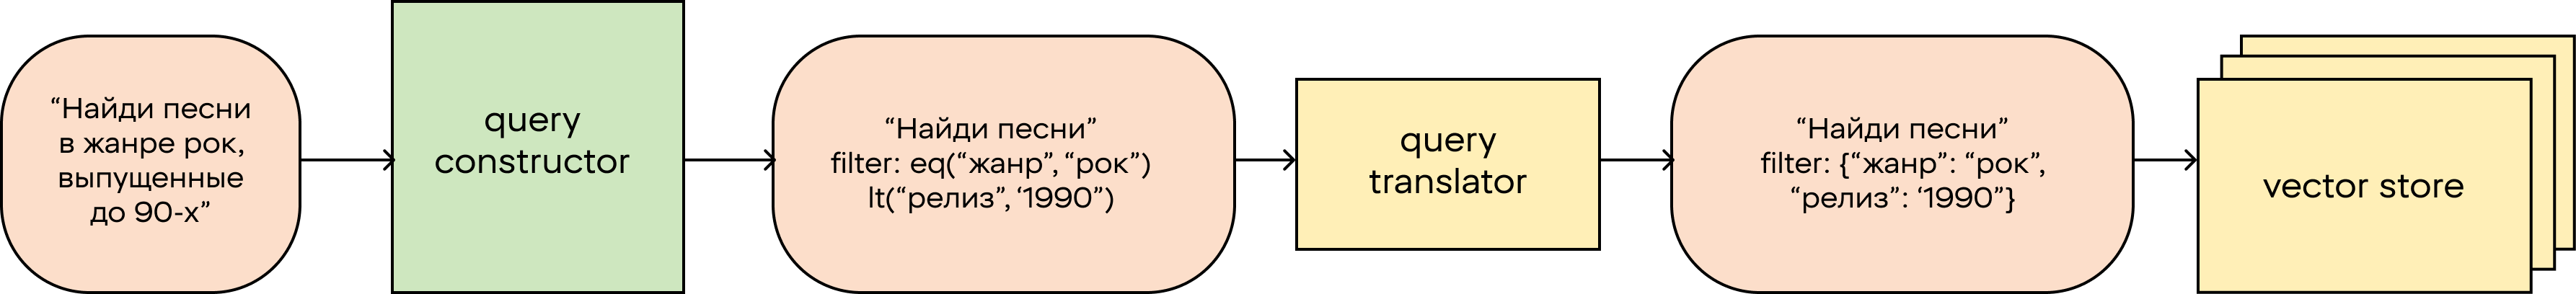

Для выделения метаданных можете воспользоваться либо генерацией json'а в определенном формате, либо SGR.

[Schema-Guided Reasoning (SGR)](https://abdullin.com/schema-guided-reasoning/) — это метод, который побуждает большие языковые модели (LLM) к созданию структурированных, понятных и предсказуемых ответов, заставляя их рассуждать по заранее определённым шагам. Создавая специальную схему (или структурированный шаблон), вы явно задаёте:

* какие этапы модель обязана пройти (не допускает пропуска или потери логики),
* в каком порядке должна происходить цепочка рассуждений (обеспечивает связность),
* на что именно следует обратить внимание (повышает глубину и точность).

Вместо свободной генерации текста — часто непоследовательной или двусмысленной — схема выступает жёстким ориентиром. Эта структура затем принудительно применяется к модели с помощью ограниченного декодирования (structured output).